In [ ]:
# Install Libraries
!pip install -q kaggle
!pip install torchmetrics

# Import Libraries
from google.colab import drive, files
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Subset
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
from torchmetrics import ConfusionMatrix, ROC, AUROC
from torchmetrics.functional import auc
from sklearn.metrics import classification_report, roc_curve, auc
import seaborn as sns
import time
import os
import copy
import matplotlib.pyplot as plt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 4.1 MB/s 


In [ ]:
# Connect to Google Drive
drive.mount('/content/drive')
print("[INFO]: Google Drive connected.")
%cd ./drive/MyDrive/colab/tumor_classification/

Mounted at /content/drive
[INFO]: Google Drive connected.
/content/drive/MyDrive/colab/tumor_classification


In [ ]:
# Download the dataset
#files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset #sartajbhuvaji/brain-tumor-classification-mri
!mkdir data2
!unzip brain-tumor-mri-dataset -d data2

In [ ]:
# Check for dataset
!ls data2

Testing  Training


In [ ]:
# Combine Testing and Training Data
!rsync -a data2/Testing/ data2/Training/

In [ ]:
# Look for available GPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("[INFO]: Running on the GPU")
    print(f"[GPU INFO]: %s" % torch.cuda.get_device_properties(device))
else:
    device = torch.device("cpu")
    print("[INFO]: Running on the CPU")

[INFO]: Running on the GPU
[GPU INFO]: _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [ ]:
# Prepare the data

random_seed= 42
validation_split = .1
shuffle_dataset = True
image_size = 128
batch_size = 32
num_workers = 2

preprocess = transforms.Compose([
                transforms.Resize(image_size),
                transforms.CenterCrop((image_size,image_size)),
                transforms.ToTensor(),
                #transforms.Grayscale(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                transforms.RandomHorizontalFlip(),
            ])
trainset=torchvision.datasets.ImageFolder(root='data/Training/', transform=preprocess)
#testset=torchvision.datasets.ImageFolder(root='data/Testing/', transform=preprocess)

dataset_size = len(trainset.imgs)
test_size = int(0.1 * dataset_size)
train_size = int(dataset_size - test_size)
print(f'[INFO]: Total Size: {dataset_size}  Train Size: {train_size}  Test Size: {test_size}')

indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, num_workers=2, sampler=train_sampler)
validationloader = torch.utils.data.DataLoader(trainset, batch_size=train_size, num_workers=2, sampler=valid_sampler)


class_names = trainset.classes
num_classes = len(class_names)
print(f'[INFO]: Number of classes: {num_classes}  Class names: {class_names}')

[INFO]: Total Size: 3160  Train Size: 2844  Test Size: 316
[INFO]: Number of classes: 4  Class names: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [ ]:
%matplotlib inline

def save_model(model):
    # Save the model
    path = "./tc_"+ model.name +".pt"
    torch.save(model, path)


def test_model(model,loader):
    # Test the model
    correct = 0
    total = 0
    with torch.no_grad():
      for data in loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        pred_softmax = torch.log_softmax(outputs.data, dim = 1)
        _, predicted = torch.max(pred_softmax, dim = 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        probabilities = predicted
        predictions = predicted.cpu()
        all_labels = labels.cpu()

      c_report = classification_report(all_labels, predictions, target_names=class_names)
      print(c_report)

      confmat = ConfusionMatrix(num_classes=num_classes)
      heatmap = confmat(predictions, all_labels)
      sns.set_theme()
      heatmap = heatmap.cpu().detach().numpy()
      ax = sns.heatmap(heatmap, annot=True, fmt="d", yticklabels=class_names, xticklabels=class_names, cmap="YlGnBu")
      fig = ax.get_figure()
      fig.tight_layout()
      heatmap_name = 'heatmap_' + model.name + '.png'
      print(heatmap_name)
      fig.savefig(heatmap_name,dpi=300) 
      
    accuracy = round(correct/total, 5)
    print(f'Accuracy: {accuracy}')

    with open('tc_statistics.txt', 'w') as f:
      f.write(c_report + '\n\nAccuracy:' + str(accuracy))

    return accuracy

valid_losses = []
train_losses = []

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    # Train the model
    since = time.time()

    best_accuracy = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 20)

        ## Training
        model.train()
        train_loss = 0
        for data, labels in trainloader:
            data = data.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        ## Validation
        model.eval()
        valid_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for data in validationloader:
              images, labels = data
              images = images.to(device)
              labels = labels.to(device)

              outputs = model(images)

              pred_softmax = torch.log_softmax(outputs.data, dim = 1)
              _, predicted = torch.max(pred_softmax, dim = 1)

              total += labels.size(0)
              correct += (predicted == labels).sum().item()
              loss = criterion(outputs, labels) 
              valid_loss += loss.item()
              

              accuracy = round(correct/total, 5)

              if accuracy > best_accuracy:
                save_model(model)
                best_accuracy = accuracy
                print(f'[INFO]: Model saved. Accuracy: {accuracy}')
                
        
        train_loss = train_loss / len(trainloader)
        valid_loss = valid_loss / len(validationloader)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        print(f'[EPOCH]: Training loss: {train_loss}   Validation Loss: {valid_loss}')
        print('-' * 90)
        plot_loss(train_losses,valid_losses,phase='epoch')
        
    time_elapsed = time.time() - since
    print(f'[TRAINING]: Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'[TRAINING]: Best val Accuracy: {best_accuracy:4f}')

    plot_loss(train_losses,valid_losses,phase='final')

def plot_loss(trainloss,validationloss,phase):
  plt.figure(figsize=(10,5))
  plt.title("Training and Validation Loss")
  plt.plot(validationloss,label="val")
  plt.plot(trainloss,label="train")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  if phase == 'final':
    plt.savefig('loss_graph.png', dpi=300)
    plt.show()
  elif phase == 'epoch':
    plt.savefig('loss_graph.png', dpi=300)
    plt.close('all')
  

In [ ]:
# Import pretrained models

def build_model(model_name, weights, pretrained=True, fine_tune=True, num_classes=2):

    # Models which have fc instead of classifier
    fc = ['googlenet',
          'regnet_y_400mf',
          'regnet_y_800mf',
          'regnet_y_1_6gf',
          'regnet_y_3_2gf',
          'regnet_y_8gf',
          'regnet_y_16gf',
          'regnet_y_32gf',
          'regnet_y_128gf',
          'regnet_x_400mf',
          'regnet_x_800mf',
          'regnet_x_1_6gf',
          'regnet_x_3_2gf',
          'regnet_x_8gf',
          'regnet_x_16gf',
          'regnet_x_32gf',
          'resnet18',
          'resnet34',
          'resnet50',
          'resnet101',
          'resnet152',
          'resnext50_32x4d',
          'resnext101_32x8d',
          'resnext101_64x4d',
          'shufflenet_v2_x0_5',
          'shufflenet_v2_x1_0',
          'shufflenet_v2_x1_5',
          'shufflenet_v2_x2_0',
          'wide_resnet50_2',
          'wide_resnet101_2']

    model_string = 'global model; model = models.' + model_name + '(weights=\'' + weights + '\')'
    exec(model_string)

    model.name = model_name

    if pretrained:
        print('[INFO]: Loading pre-trained weights...')
    else:
        print('[INFO]: Not loading pre-trained weights.')
    
    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True
    elif not fine_tune:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False
    
    if(model_name in fc):
      num_ftrs = model.fc.in_features
      model.fc = nn.Linear(in_features = num_ftrs, out_features = num_classes)
    elif(model_name == 'inception_v3'):
      aux_features = model.AuxLogits.fc.in_features
      fc_features = model.fc.in_features
      model.AuxLogits.fc = nn.Linear(aux_features, num_classes)
      model.fc = nn.Linear(fc_features, num_classes)
    elif(model_name == 'squeezenet1_0' or model_name == 'squeezenet1_1'):
      in_chn = model.classifier[1].in_channels
      model.classifier[1] = nn.Conv2d(in_channels = in_chn, out_channels = num_classes, kernel_size = (1,1), stride = (1,1))
    elif(model_name == 'swin_t' or model_name == 'swin_s' or model_name == 'swin_b'):
      num_ftrs = model.head.in_features
      model.head = nn.Linear(in_features = num_ftrs, out_features = num_classes)
    elif(model_name == 'vit_b_16' or model_name == 'vit_b_32' or model_name == 'vit_l_16' or model_name == 'vit_l_32' or model_name == 'vit_h_14'):
      num_ftrs = model.heads.head.in_features
      model.heads.head = nn.Linear(in_features = num_ftrs, out_features = num_classes)
    else:
      last_layer = model.classifier[-1]
      num_ftrs = last_layer.in_features
      model.classifier[-1] = nn.Linear(in_features = num_ftrs, out_features = num_classes)

    return model



model = build_model(model_name = 'resnet50', weights = 'DEFAULT', pretrained = True, fine_tune = True, num_classes = 4)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
#criterion = nn.BCEWithLogitsLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

[INFO]: Loading pre-trained weights...
[INFO]: Fine-tuning all layers...


In [ ]:
# Import fine-tuned pretrained model

model = torch.load('tumor_classification_model.pt')

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [ ]:
# Custom CNN Model

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self.conv4 = nn.Conv2d(128, 256, 5)
        self.fc1 = nn.Linear(256*12*12, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 4)

    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
# Empty GPU Cache
torch.cuda.empty_cache()

# Empty Swap
!swapoff -a && swapon -a

#torch.cuda.memory_summary(device=None, abbreviated=False)
#torch.cuda.memory_stats(device=device)

Epoch 1/40
--------------------
[INFO]: Model saved. Accuracy: 0.65823
[EPOCH]: Training loss: 1.146905597006337   Validation Loss: 0.8633953332901001
------------------------------------------------------------------------------------------
Epoch 2/40
--------------------
[INFO]: Model saved. Accuracy: 0.81646
[EPOCH]: Training loss: 0.6080959944912557   Validation Loss: 0.5282436013221741
------------------------------------------------------------------------------------------
Epoch 3/40
--------------------
[INFO]: Model saved. Accuracy: 0.88291
[EPOCH]: Training loss: 0.3507322799623682   Validation Loss: 0.33691510558128357
------------------------------------------------------------------------------------------
Epoch 4/40
--------------------
[INFO]: Model saved. Accuracy: 0.89557
[EPOCH]: Training loss: 0.2275897916615679   Validation Loss: 0.32370561361312866
------------------------------------------------------------------------------------------
Epoch 5/40
----------------

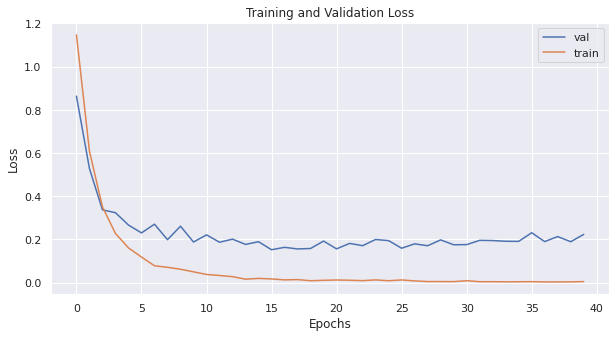

In [ ]:
# Train the model
train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=40)

In [ ]:
# Save the model
torch.save(model,'tumor_classification_model.pt')

                  precision    recall  f1-score   support

    glioma_tumor       0.98      0.93      0.95       108
meningioma_tumor       0.91      0.94      0.93        86
        no_tumor       0.92      0.95      0.94        38
 pituitary_tumor       0.98      1.00      0.99        84

        accuracy                           0.95       316
       macro avg       0.95      0.95      0.95       316
    weighted avg       0.95      0.95      0.95       316

heatmap_resnet50.png
Accuracy: 0.95253


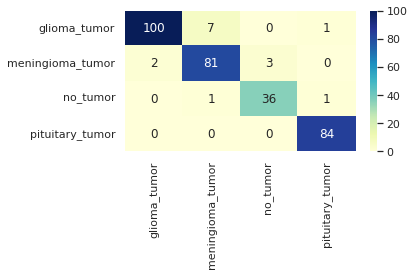

In [ ]:
# Load and Test the model
PATH = 'tc_resnet50.pt'

if torch.cuda.is_available():
  model = torch.load(PATH)
  model.to(device)
else:
  model = torch.load(PATH, map_location=device)

model.eval()

test = test_model(model,validationloader)